In [2]:
%jsroot on

gInterpreter->AddIncludePath("/usr/local/include");
gSystem->Load("/usr/local/lib/libErrorAnalysis");
gSystem->Load("/usr/local/lib/libLabTools");
gSystem->Load("/usr/local/lib/libBode");

Modellazione e analisi dati diretta in laboratorio: 29 marzo 2022


In [3]:
#include<fstream>

In [4]:
#include<LabPlot.h> 

In [5]:
set_atlas_style(30);

Applying ATLAS style settings


In [6]:
double get_TRangeErr(double range1, double errPercent = 0.0016, int partition = 10){
    return range1 * errPercent * partition / sqrt(3);
}

In [7]:
#include<LabTools.h> 

In [8]:
#include<ErrorAnalysis.h>

In [9]:
#include<LabStat.h>

In [18]:
TCanvas *c1 = new TCanvas("", "", 800, 700);

std::ifstream uedge_analog_data("../dati/uedge_analog_data_220329.txt");
std::ifstream dedge_analog_data("../dati/dedge_analog_data_220329.txt");


Double_t offset_tmp = 0.19; // offset di misura (initial guess)
Double_t diametro_spk = 0.05985; // 2*offset verticale (da aggiungere in quadratura)

TGraphErrors *u_ag_g = new TGraphErrors();
TGraphErrors *d_ag_g = new TGraphErrors();

u_ag_g->GetXaxis()->CenterTitle();
u_ag_g->GetYaxis()->CenterTitle();

Double_t d, t, fst;

TLegend *l = new TLegend(0.2, 0.65, 0.5, 0.9);
l->SetFillColorAlpha(0, 0.75);
l->SetTextSize(25);
l->SetHeader("#bf{Analogic} #it{Preliminary}");

for(int i=0; uedge_analog_data>>d>>t>>fst; i++){
    
    u_ag_g->SetPoint(i, d, t);
    u_ag_g->SetPointError(i, 0.001/std::sqrt(3), get_TRangeErr(fst));
}

for(int i=0; dedge_analog_data>>d>>t>>fst; i++){
    
    d_ag_g->SetPoint(i, d, t);
    d_ag_g->SetPointError(i, 0.001/std::sqrt(3), get_TRangeErr(fst));
}

### Fit: quale funzione vogliamo utilizzare?

Abbiamo effettuato il fit considerando una funzione lineare, per cui (ipotizzando che ricevitore ed emettitore siano in asse abbiamo che $d = v_s\cdot t.$ Dobbiamo però considerare la possibilità di un errore sistematico di offset sulla distanza $d$, quindi rendendo la funzione di fit simile a $d=d_\text{offset}+v_st.$

Però abbiamo che potremmo non avere in perfetto asse i due strumenti e quindi la necessità di avere un offset laterale, per cui la distanza che in realtà compie è $d_\text{true}=\sqrt{d_\text{meas} + \delta_\text{lat}}.$ Così facendo abbiamo che però non funziona il fit per il secondo set di dati, mentre con il primo abbiamo un miglior rendimento (Prob($\chi^2$) > 70%). Inoltre in tale modo i rusultati non vengono compatibili.

Funzione con approssimazione ad ordime maggiore sarebbe quindi $$d=\sqrt{v_s^2t^2 + \text{(offset)}^2 -\delta^2 + 2\text{(offset)}v_st},$$ oppure $$t = \frac{1}{v_s}\sqrt{d^2+\delta^2}+\frac{\text{offset}}{v_s}.$$

In [14]:


TF1 *u_ag_f = new TF1("u_ag_f", "[0]+x*[1]");

u_ag_f->SetParameters(offset_tmp/340, 1/340);
u_ag_f->SetParameter(2, std::pow(diametro_spk/2, 2));

TF1 *d_ag_f = new TF1("d_ag_f", "[0]+x*[1]");

d_ag_f->SetParameters(offset_tmp/340, 1/340);
//d_ag_f->SetParameter(2, std::pow(diametro_spk/2, 2));

u_ag_g->SetTitle(";Distance [m];Delay [ms]");

u_ag_g->Draw("ap");
u_ag_g->Fit("u_ag_f");
l->AddEntry(u_ag_g, "Up edge triggered", "LPE");

d_ag_g->SetMarkerColor(kRed);
d_ag_g->SetLineColor(kRed);
d_ag_f->SetLineColor(kRed);

d_ag_g->Draw("p");
d_ag_g->Fit("d_ag_f");
l->AddEntry(d_ag_g, "Down edge triggered", "LPE");

l->Draw();

 FCN=20.2347 FROM MIGRAD    STATUS=CONVERGED      72 CALLS          73 TOTAL
                     EDM=2.17311e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -4.21511e-01   1.97068e-03   1.20891e-06  -8.74080e-02
   2  p1           2.87307e+00   5.39452e-03   3.30922e-06   6.93095e-03
 FCN=1.20962 FROM MIGRAD    STATUS=CONVERGED      74 CALLS          75 TOTAL
                     EDM=1.18502e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0          -3.65710e-01   3.65261e-03   6.14674e-07  -5.51057e-01
   2  p1           2.85823e+00   8.43392e-03   1.41926e-06  -2.15713e-01


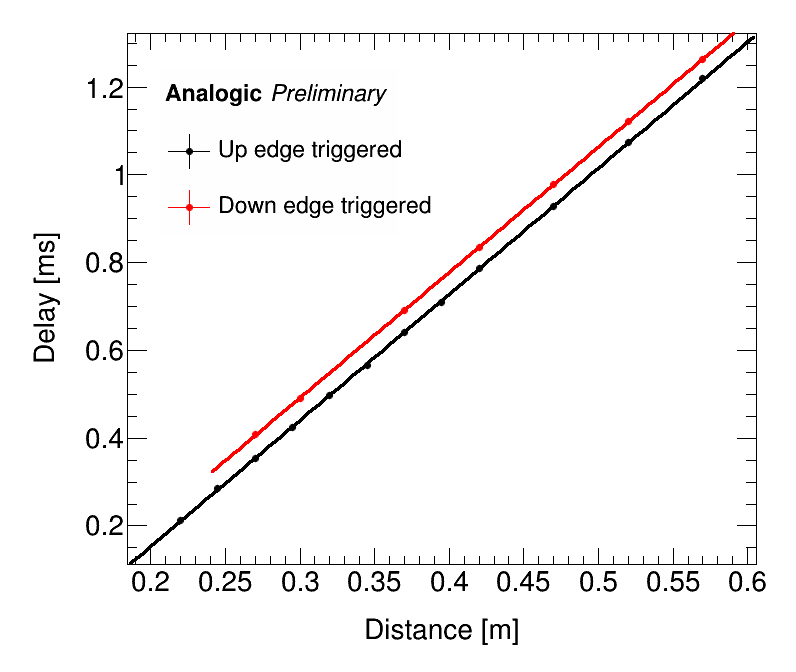


** CHI2 / NDF ( PROB. ) 20.2347 / 10 ( 0.0271097 )


** CHI2 / NDF ( PROB. ) 1.20962 / 5 ( 0.943952 )

COMPATIBILE:	significativita' statistica  1.482615 σ


In [15]:
%jsroot off
c1->Draw();

logs::print_stat(u_ag_f);
logs::print_stat(d_ag_f);

std::cout << LabStat::compatible_nocorr(u_ag_f->GetParameter(1), u_ag_f->GetParError(1), 
                                        d_ag_f->GetParameter(1), d_ag_f->GetParError(1)) << ":\t"
    << LabStat::get_statsign(u_ag_f->GetParameter(1), u_ag_f->GetParError(1), 
                             d_ag_f->GetParameter(1), d_ag_f->GetParError(1)) << "\n";

In [16]:
c1->Print("../fig/analog_plot_d1.pdf")

Info in <TCanvas::Print>: pdf file ../fig/analog_plot_d1.pdf has been created


In [17]:

Double_t inverse_sspeed_ag[1] = {LabStat::getbestvalue(u_ag_f->GetParameter(1), u_ag_f->GetParError(1), 
                                                       d_ag_f->GetParameter(1), d_ag_f->GetParError(1))};
Double_t inverse_sspeed_ag_err[1] = {LabStat::getbestvalueerr(u_ag_f->GetParError(1), d_ag_f->GetParError(1))};




Double_t sspeed_ag = 1/inverse_sspeed_ag[0];
Double_t sspeed_ag_err = inverse_sspeed_ag_err[0]/pow(inverse_sspeed_ag[0], 2);


std::cout << sspeed_ag*1000 << " +- " << sspeed_ag_err*1000 << " m/s \n";

348.583 +- 0.552194 m/s 
